# Step Two Build Single Photon Model
* synchronises every trace to the middle of the acquisition window
* averages down the traces to create a first approximation of an average pulse
* use this first approximation to build a model
* fit all the traces again using this model, and use the fitted offset values to synchronise the pulses again
* once synchronised, average down to create a better approximation of a single photon model

In [278]:
from __future__ import division
import tqdm, os, sys
sys.path.append('/mnt/disk0/home/jianwei_leejw/scripts/TESPulseFitCode')
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob

import trace_param as tp
import heralded_pulses_analysis as hpa
import pulse_averaging_cw as pacw
import pulse_utils as pu
results_directory = './'

In [264]:
# Import Single Photon Filelist
filelist_1ph = np.loadtxt(results_directory + 'filelist_single_photon.dat', dtype='string')
num_of_1ph_traces = len(filelist_1ph)
sample_size = 10000
print('{} of {} n=1 traces will be sampled for creating the single photon model'.format(sample_size, num_of_1ph_traces))

10000 of 150998 n=1 traces will be sampled for creating the single photon model


In [259]:
# Import/Set discriminator settings
[height_th, offset] = np.loadtxt(results_directory + 'disc_settings.dat')
offset = int(offset)

In [265]:
# Synchronise each single photon pulse to t = 0
# Generate average pulse
reload(pacw)
time_p, signal_p = pacw.trace_ave(filelist_1ph[:sample_size], 
                                  high_th = height_th,
                                  low_th = 0,
                                  offset = offset)

In [274]:
# Use average pulse to generate single photon model
def one_pulse(x, x_offset=0, amplitude=1):
    """convert the sample single photon pulse into a function
    that can be used in a fit
    """
    x = x - x_offset
    return amplitude * np.interp(x, time_p, signal_p)

fit_model = Model(one_pulse)

In [275]:
# Use model to generate another model that has horizontal offset correction
reload(pacw)
time_f, signal_f, sigma_f = pacw.fit_corrected_pulse(filelist_1ph[:sample_size],
                                                     high_th = height_th,
                                                     low_th = 0,
                                                     offset = offset,
                                                     fit_model = fit_model)

risetime = 127.99999638 ns


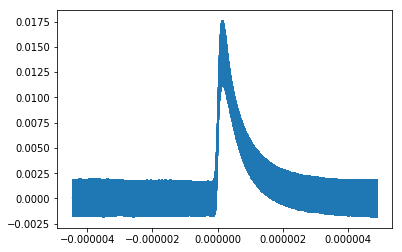

In [276]:
# Plot model with rise time
plt.figure()
plt.errorbar(time_f, signal_f, yerr=sigma_f)
print 'risetime = {} ns'.format(pu.rise_time(time_f,signal_f,plot=False)*1e9)
plt.show()

# Save single photon model with uncertainty

In [279]:
np.savetxt(results_directory + 'ph1_model_from_cw_disc.dat',
           np.array(zip(time_f, signal_f, sigma_f)),
           delimiter = '\t',
           header='time\tsignal\tsigma')

In [272]:
a = np.genfromtxt('ph1_model_from_cw_disc.dat',names=True)